# Multilayer perceptron - Toy data

In [1]:
import numpy as np
import torch
import torch.nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import plotly.express as px

seed = 1337
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

In [2]:
LABELS = [0, 0, 1, 1]
CENTERS = [(-3, -3), (3, 3), (3, -3), (-3, 3)]

def get_toy_data(batch_size, centers=CENTERS, labels=LABELS):
    x_data = []
    y_targets = np.zeros(batch_size)
    n_centers = len(centers)
    for batch_i in range(batch_size):
        center_idx = np.random.randint(0, n_centers)
        x_data.append(np.random.normal(loc=centers[center_idx]))
        y_targets[batch_i] = labels[center_idx]
    return (torch.tensor(np.array(x_data), dtype=torch.float),
            torch.tensor(y_targets, dtype=torch.float))

x_data, y_truth = get_toy_data(10)
x_data, y_truth

(tensor([[-4.4274,  3.3006],
         [ 1.0477,  2.5563],
         [-4.7226, -2.0382],
         [ 2.4427, -2.6628],
         [ 2.7462,  2.2493],
         [ 2.9620,  3.3240],
         [-5.2556,  2.3092],
         [-3.6995, -2.4170],
         [ 2.7298, -1.9658],
         [ 2.6673,  1.7689]]),
 tensor([1., 0., 0., 1., 0., 0., 1., 0., 1., 0.]))

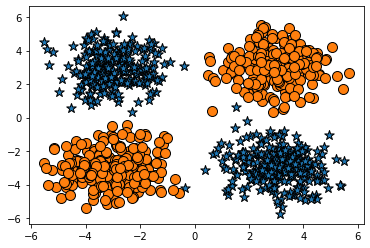

In [3]:
def plot_toy_data(x_data, y_truth, perceptron=None):
    blue = []
    orange = []
    black_blue = []
    black_orange = []
    if perceptron:
        _, y_pred = torch.max(perceptron(x_data, apply_softmax=True), dim=1)
        #y_pred = (y_pred > 0.5).float()
    else:
        y_pred = y_truth

    for x_i, y_true_i, y_pred_i in zip(x_data, y_truth, y_pred):
        
        is_black = y_true_i != y_pred_i

        if y_true_i == 1.:
            if is_black:
                black_blue.append(x_i)
            else:
                blue.append(x_i)
        else:
            if is_black:
                black_orange.append(x_i)
            else:
                orange.append(x_i)
    
    if blue:
        blue = np.stack(blue)
        plt.scatter(blue[:,0], blue[:,1], marker="*", c="tab:blue", edgecolor="black", s=100)
    
    if orange:
        orange = np.stack(orange)
        plt.scatter(orange[:,0], orange[:,1], marker="o", c="tab:orange", edgecolor="black", s=100)

    if perceptron:
        if black_blue:
            black_blue = np.stack(black_blue)
            plt.scatter(black_blue[:,0], black_blue[:,1], marker="*", c="black", s=100)
        if black_orange:
            black_orange = np.stack(black_orange)
            plt.scatter(black_orange[:,0], black_orange[:,1], marker="o", c="black", s=100)

        # hyperplane
        xx = np.linspace(x_data[:,0].min() - 0.5, x_data[:,0].max() + 0.5, 30)
        yy = np.linspace(x_data[:,1].min() - 0.5, x_data[:,1].max() + 0.5, 30)
        xv, yv = np.meshgrid(xx, yy)
        xy = np.vstack([xv.ravel(), yv.ravel()]).T
        z = perceptron(torch.tensor(xy, dtype=torch.float), apply_softmax=True)[:,1].detach().numpy().reshape(yv.shape)
        
        plt.contour(xx, yy, z, colors='k', linestyles=['--', '-', '--'], levels=[0.4, 0.5, 0.6])
    plt.show()

toy_data = get_toy_data(1024)
plot_toy_data(*toy_data)



In [4]:
class MultilayerPerceptron(torch.nn.Module):
    def __init__(self, input_size, hidden_size=2, output_size=3, 
                 num_hidden_layers=1, hidden_activation=torch.nn.Sigmoid):
        super(MultilayerPerceptron, self).__init__()
        self.module_list = torch.nn.ModuleList()
        
        interim_input_size = input_size
        interim_output_size = hidden_size
        
        for _ in range(num_hidden_layers):
            self.module_list.append(torch.nn.Linear(interim_input_size, interim_output_size))
            self.module_list.append(hidden_activation())
            interim_input_size = interim_output_size

        self.fc_final = torch.nn.Linear(interim_input_size, output_size)
        self.last_forward_cache = []
    
    def forward(self, x, apply_softmax=False):
        self.last_forward_cache = []
        self.last_forward_cache.append(x.to("cpu").numpy())

        for module in self.module_list:
            x = module(x)
            self.last_forward_cache.append(x.to("cpu").data.numpy())
            
        output = self.fc_final(x)
        self.last_forward_cache.append(output.to("cpu").data.numpy())

        if apply_softmax:
            output = F.softmax(output, dim=1)
        

        return output



# MLP0 - Multilayer Perceptron (0 hidden layers)

In [5]:
def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

MultilayerPerceptron(
  (module_list): ModuleList()
  (fc_final): Linear(in_features=2, out_features=2, bias=True)
)


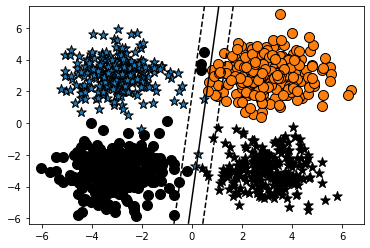

In [6]:
set_random_seed(42)

mlp0 = MultilayerPerceptron(input_size=2, 
                            hidden_size = 2, #  isn't ever used but we still set it
                            num_hidden_layers=0, 
                            output_size=len(set(LABELS)))
print(mlp0)


x_data_static, y_truth_static = get_toy_data(1000)

plot_toy_data(x_data_static, y_truth_static, mlp0)

In [7]:
def train_routine(mlp, x_data_static, y_truth_static):
    losses = []
    batch_size = 1000
    n_batches = 10
    max_epochs = 20

    loss_change = 1.0
    last_loss = 10.0
    change_threshold = 1e-3
    epoch = 0

    lr = 0.01

    optimizer = torch.optim.Adam(params=mlp.parameters(), lr=lr)
    cross_ent_loss = torch.nn.CrossEntropyLoss()

    def early_termination(loss_change, change_threshold, epoch, max_epochs):
        terminate_for_loss_change = loss_change < change_threshold
        terminate_for_epochs = epoch > max_epochs
        
        #return terminate_for_loss_change or 
        return terminate_for_epochs

    while not early_termination(loss_change, change_threshold, epoch, max_epochs):

        for _ in range(n_batches):
            # step 0: fetch the data
            x_data, y_target = get_toy_data(batch_size)
    
            # step 1: zero the gradients
            mlp.zero_grad()
            
            # step 2: run the forward pass
            y_pred = mlp(x_data).squeeze()
            
            # step 3: compute the loss
            loss = cross_ent_loss(y_pred, y_target.long())

            # step 4: compute the backward pass
            loss.backward()
            
            # step 5: have the optimizer take an optimization step
            optimizer.step()

            # auxillary: bookkeeping
            loss_value = loss.item()
            losses.append(loss_value)
            loss_change = abs(last_loss - loss_value)
            last_loss = loss_value

        print(f"epoch: {epoch} loss: {loss_value:0.3}")  
        
        plot_toy_data(x_data_static, y_truth_static, mlp)
        epoch += 1

epoch: 0 loss: 0.932


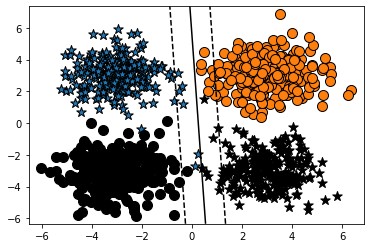

epoch: 1 loss: 0.801


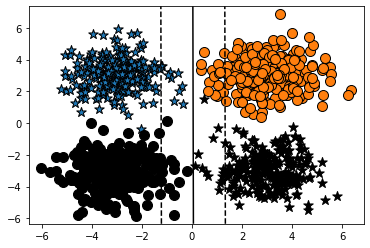

epoch: 2 loss: 0.727


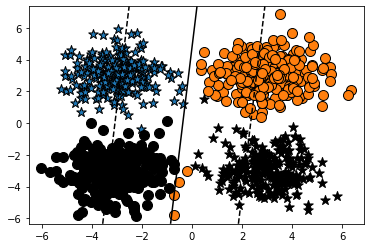

epoch: 3 loss: 0.694


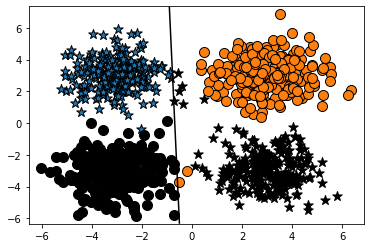

epoch: 4 loss: 0.698


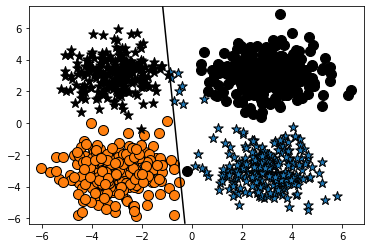

epoch: 5 loss: 0.692


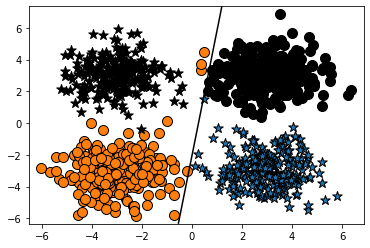

epoch: 6 loss: 0.695


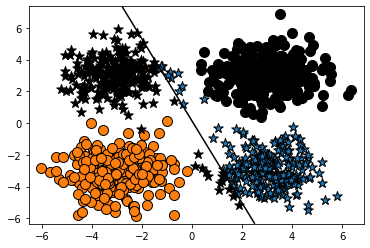

epoch: 7 loss: 0.693


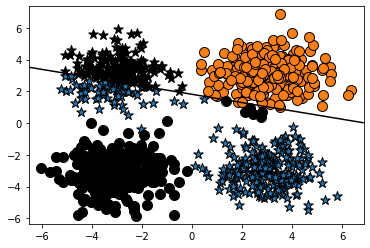

epoch: 8 loss: 0.693


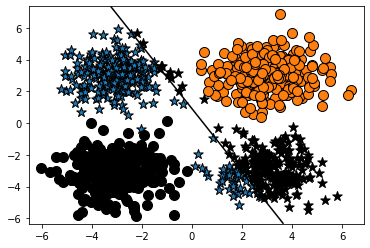

epoch: 9 loss: 0.695


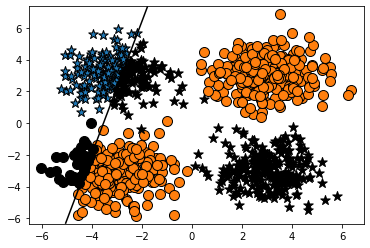

epoch: 10 loss: 0.693


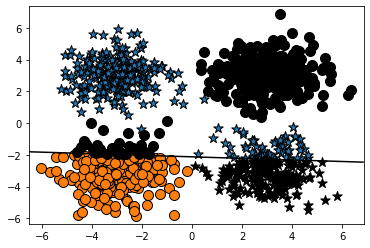

epoch: 11 loss: 0.693


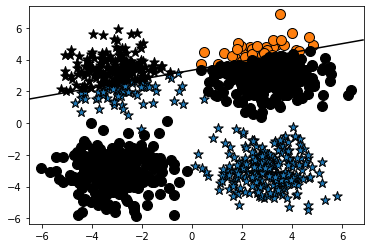

epoch: 12 loss: 0.694


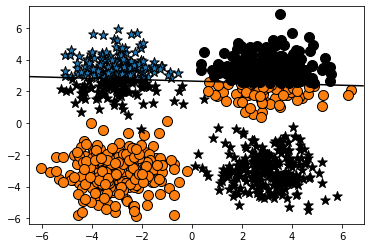

epoch: 13 loss: 0.694


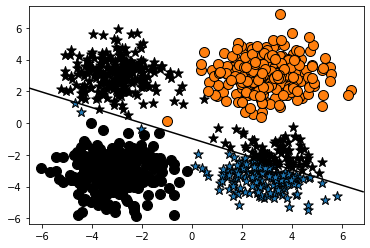

epoch: 14 loss: 0.694


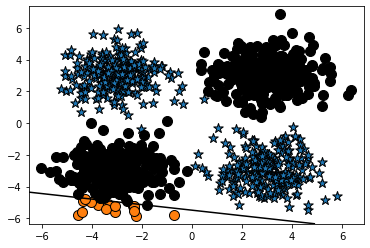

epoch: 15 loss: 0.692


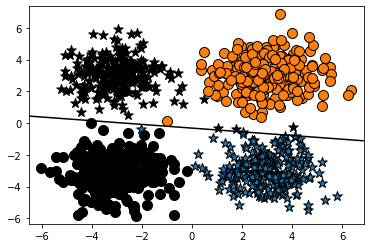

epoch: 16 loss: 0.693


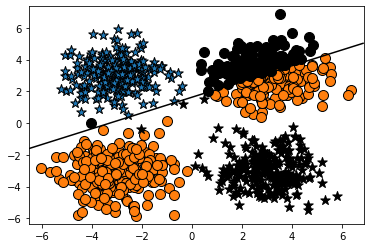

epoch: 17 loss: 0.693


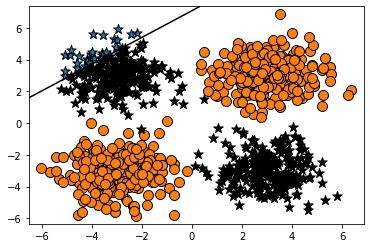

epoch: 18 loss: 0.693


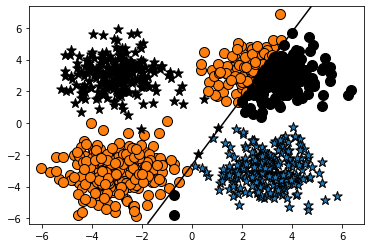

epoch: 19 loss: 0.693


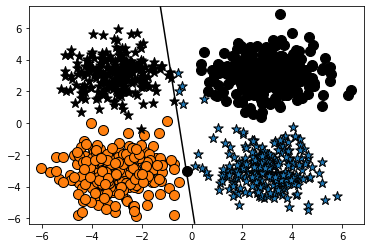

epoch: 20 loss: 0.693


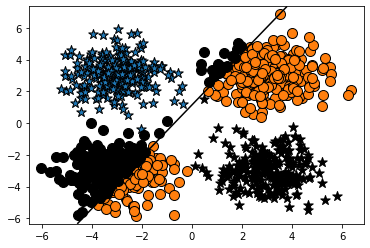

In [8]:
train_routine(mlp0, x_data_static, y_truth_static)

# MLP1 - Multilayer Perceptron (1 hidden layer)

In [9]:
set_random_seed(2)

mlp1 = MultilayerPerceptron(input_size=2, 
                            hidden_size=2, 
                            num_hidden_layers=1, 
                            output_size=len(set(LABELS)))
mlp1

MultilayerPerceptron(
  (module_list): ModuleList(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): Sigmoid()
  )
  (fc_final): Linear(in_features=2, out_features=2, bias=True)
)

epoch: 0 loss: 0.693


/var/folders/d4/99p6n42d68n6p_17gkrstw7h0000gn/T/ipykernel_73510/2992759035.py:50: UserWarning: No contour levels were found within the data range.
  plt.contour(xx, yy, z, colors='k', linestyles=['--', '-', '--'], levels=[0.4, 0.5, 0.6])


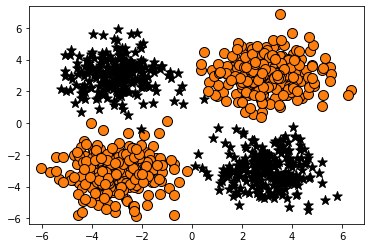

epoch: 1 loss: 0.693


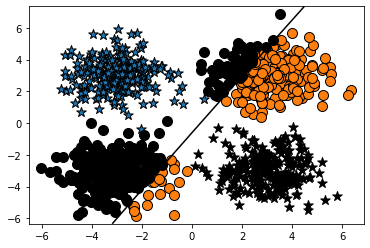

epoch: 2 loss: 0.691


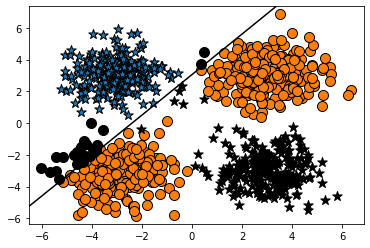

epoch: 3 loss: 0.687


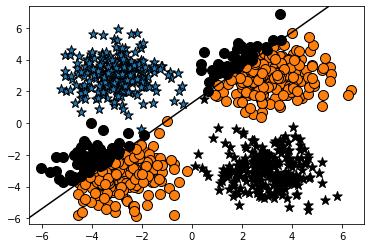

epoch: 4 loss: 0.681


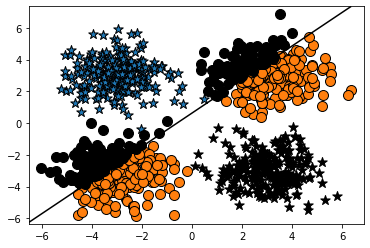

epoch: 5 loss: 0.673


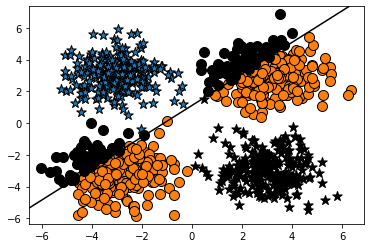

epoch: 6 loss: 0.659


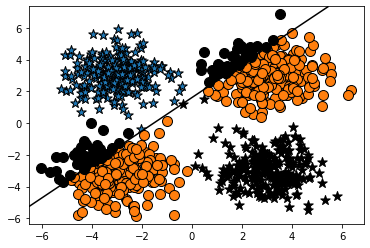

epoch: 7 loss: 0.632


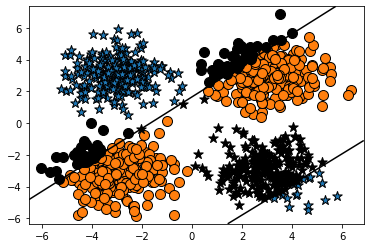

epoch: 8 loss: 0.598


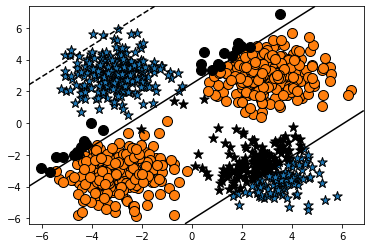

epoch: 9 loss: 0.555


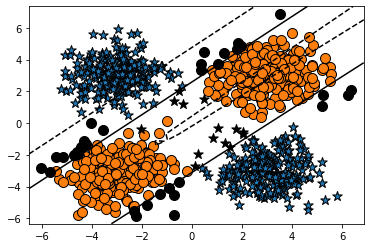

epoch: 10 loss: 0.517


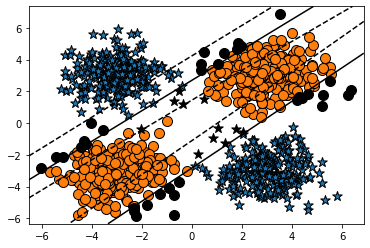

epoch: 11 loss: 0.476


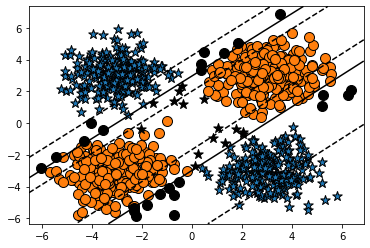

epoch: 12 loss: 0.437


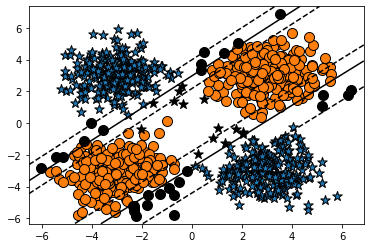

epoch: 13 loss: 0.388


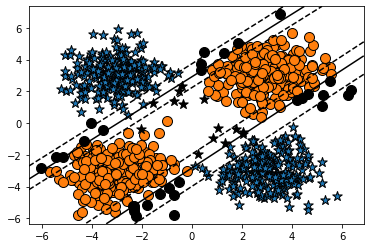

epoch: 14 loss: 0.359


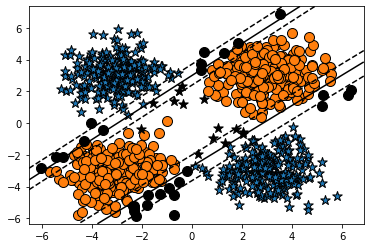

epoch: 15 loss: 0.326


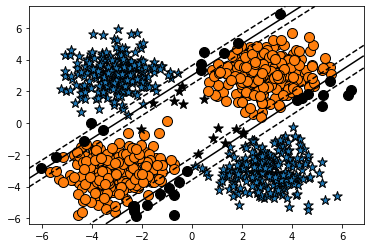

epoch: 16 loss: 0.313


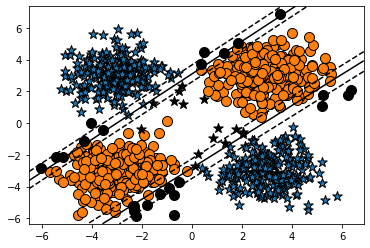

epoch: 17 loss: 0.284


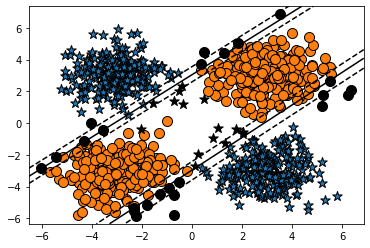

epoch: 18 loss: 0.253


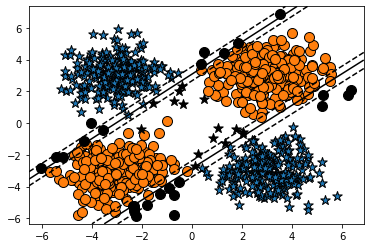

epoch: 19 loss: 0.239


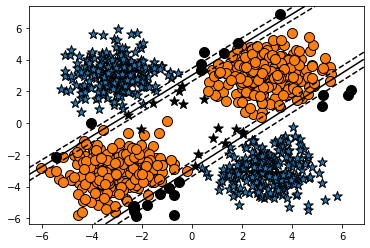

epoch: 20 loss: 0.233


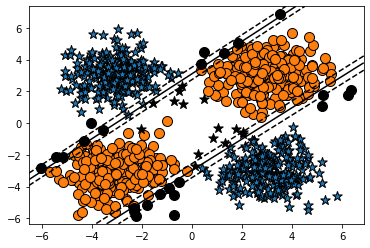

In [10]:
train_routine(mlp1, x_data_static, y_truth_static)

# MLP2 - Multilayer Perceptron (2 hidden layers)

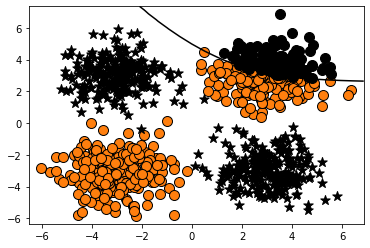

In [11]:
set_random_seed(399)

mlp2 = MultilayerPerceptron(input_size=2, 
                           hidden_size=2, 
                           num_hidden_layers=2, 
                           output_size=len(set(LABELS)))
mlp2
plot_toy_data(x_data_static, y_truth_static, mlp2)

epoch: 0 loss: 0.698


/var/folders/d4/99p6n42d68n6p_17gkrstw7h0000gn/T/ipykernel_73510/2992759035.py:50: UserWarning: No contour levels were found within the data range.
  plt.contour(xx, yy, z, colors='k', linestyles=['--', '-', '--'], levels=[0.4, 0.5, 0.6])


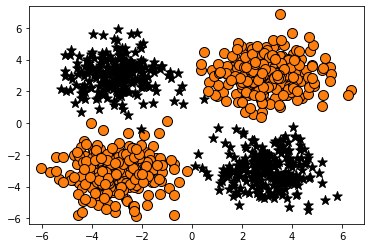

epoch: 1 loss: 0.695


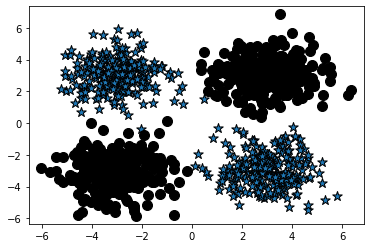

epoch: 2 loss: 0.691


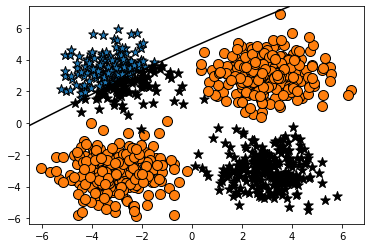

epoch: 3 loss: 0.69


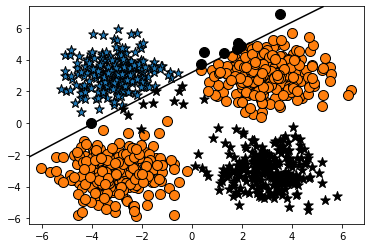

epoch: 4 loss: 0.687


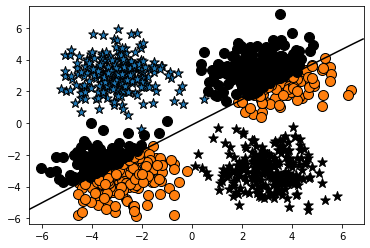

epoch: 5 loss: 0.683


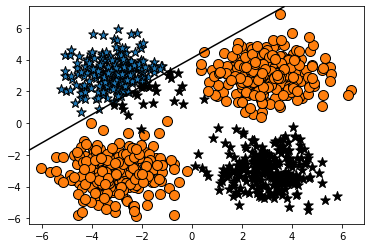

epoch: 6 loss: 0.675


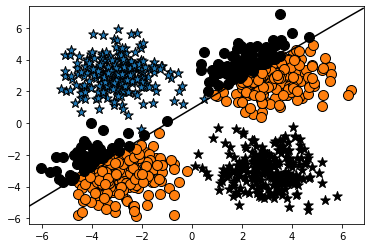

epoch: 7 loss: 0.664


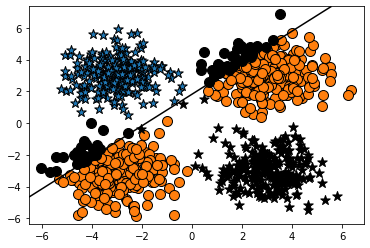

epoch: 8 loss: 0.648


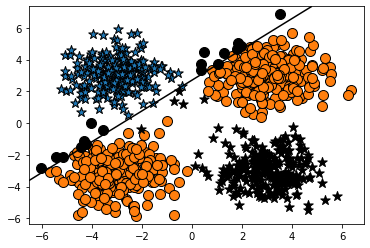

epoch: 9 loss: 0.63


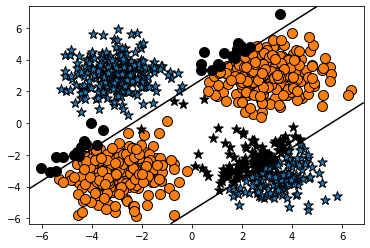

epoch: 10 loss: 0.601


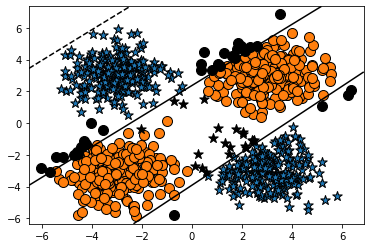

epoch: 11 loss: 0.566


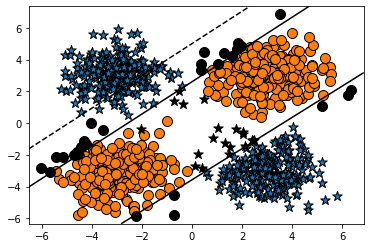

epoch: 12 loss: 0.532


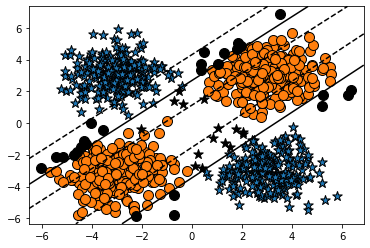

epoch: 13 loss: 0.488


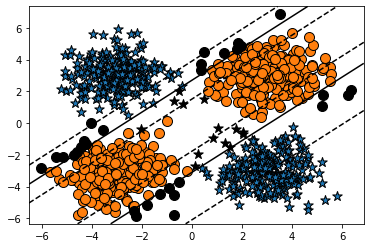

epoch: 14 loss: 0.445


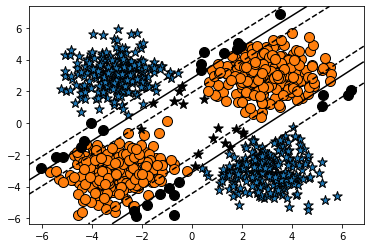

epoch: 15 loss: 0.399


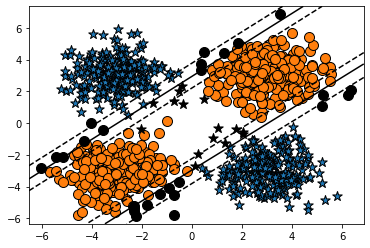

epoch: 16 loss: 0.364


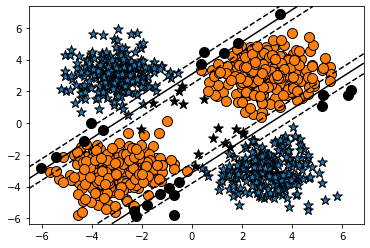

epoch: 17 loss: 0.325


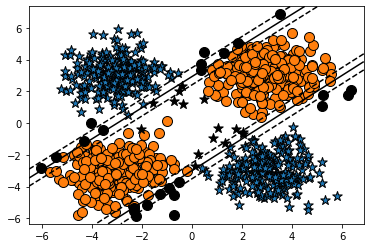

epoch: 18 loss: 0.288


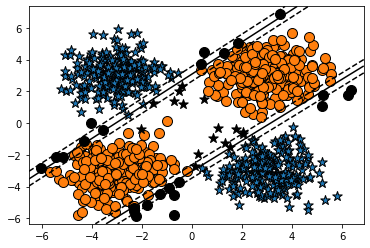

epoch: 19 loss: 0.256


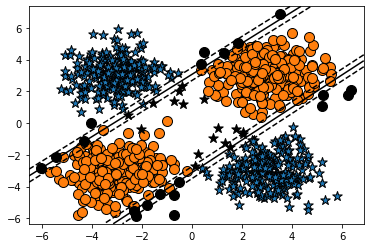

epoch: 20 loss: 0.232


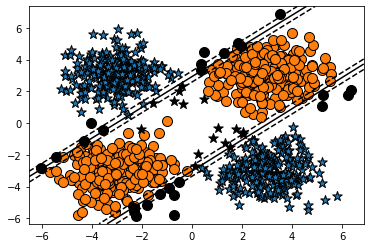

In [12]:
train_routine(mlp2, x_data_static, y_truth_static)

# MYMLP2 - Multilayer Perceptron (2 hidden layers) 

In [13]:
class MyMultilayerPerceptron(torch.nn.Module):
    def __init__(self, sizes, hidden_activation=torch.nn.Sigmoid):
        super(MyMultilayerPerceptron, self).__init__()
        self.module_list = torch.nn.ModuleList()
        
        for i in range(1, len(sizes) - 1):
            in_size = sizes[i-1]
            out_size = sizes[i]
            self.module_list.append(torch.nn.Linear(in_size, out_size))
            self.module_list.append(hidden_activation())

        in_size = sizes[-2]
        out_size = sizes[-1]
        self.fc = torch.nn.Linear(in_size, out_size)
            
        self.last_forward_cache = []
       
    def forward(self, x, apply_softmax=False):
        self.last_forward_cache = []
        self.last_forward_cache.append(x.to("cpu").numpy())

        for module in self.module_list:
            x = module(x)
            self.last_forward_cache.append(x.to("cpu").data.numpy())
            
        output = self.fc(x)
        self.last_forward_cache.append(output.to("cpu").data.numpy())

        if apply_softmax:
            output = F.softmax(output, dim=1)
        return output



epoch: 0 loss: 0.693


/var/folders/d4/99p6n42d68n6p_17gkrstw7h0000gn/T/ipykernel_73510/2992759035.py:50: UserWarning: No contour levels were found within the data range.
  plt.contour(xx, yy, z, colors='k', linestyles=['--', '-', '--'], levels=[0.4, 0.5, 0.6])


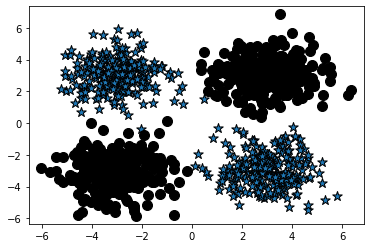

epoch: 1 loss: 0.69


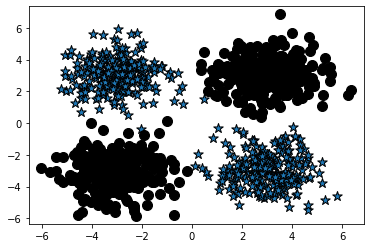

epoch: 2 loss: 0.689


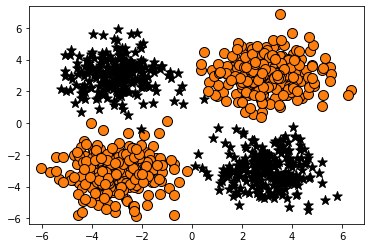

epoch: 3 loss: 0.686


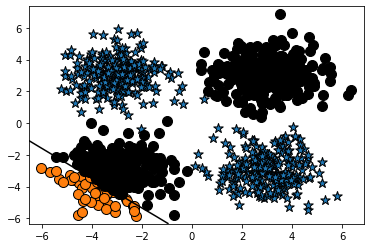

epoch: 4 loss: 0.678


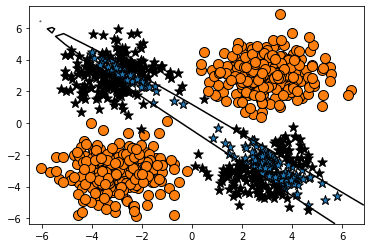

epoch: 5 loss: 0.668


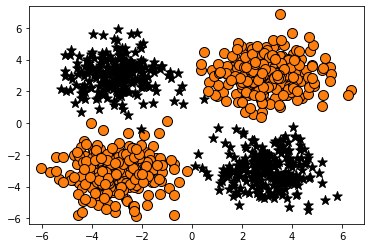

epoch: 6 loss: 0.654


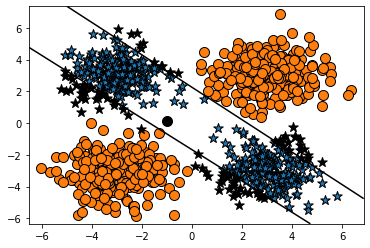

epoch: 7 loss: 0.635


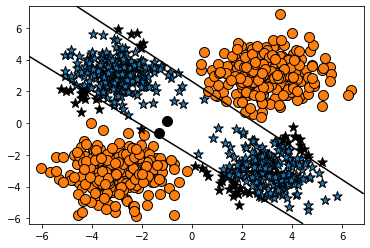

epoch: 8 loss: 0.608


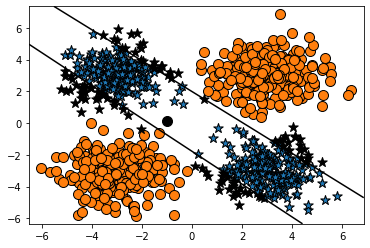

epoch: 9 loss: 0.58


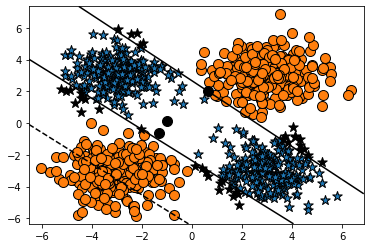

epoch: 10 loss: 0.539


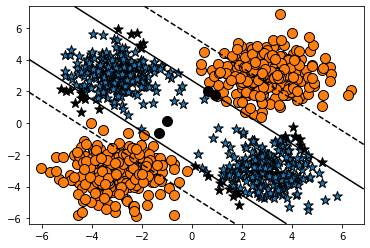

epoch: 11 loss: 0.497


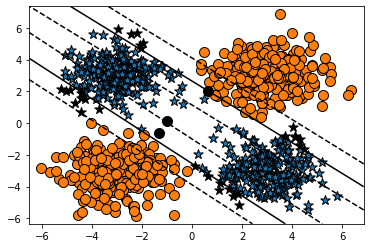

epoch: 12 loss: 0.443


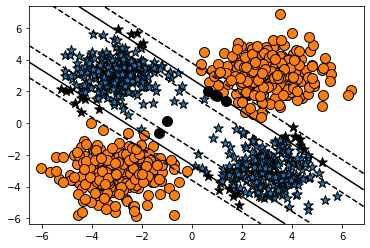

epoch: 13 loss: 0.396


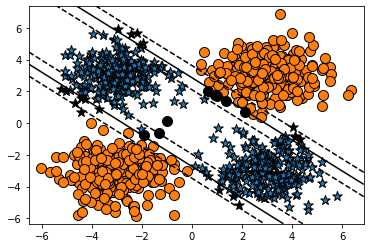

epoch: 14 loss: 0.346


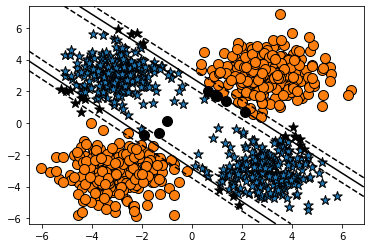

epoch: 15 loss: 0.303


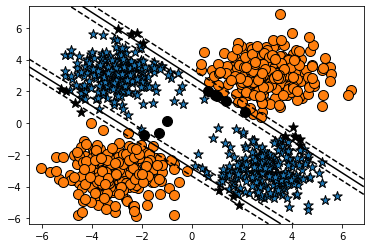

epoch: 16 loss: 0.255


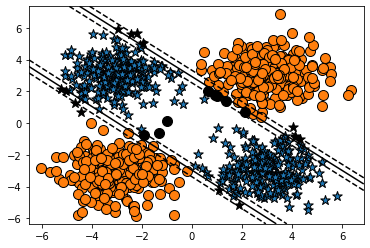

epoch: 17 loss: 0.234


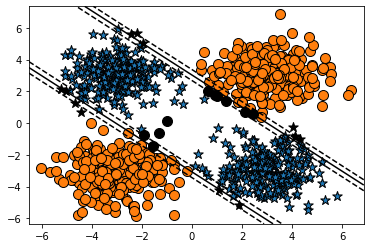

epoch: 18 loss: 0.191


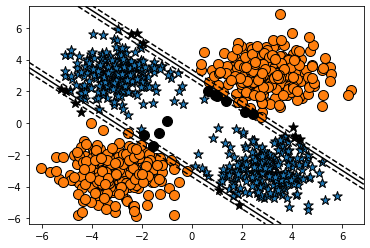

epoch: 19 loss: 0.17


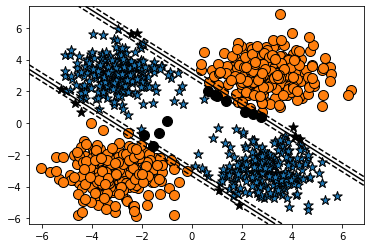

epoch: 20 loss: 0.162


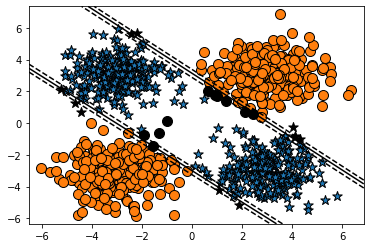

In [14]:
set_random_seed(23)
mymlp2 = MyMultilayerPerceptron(sizes=[2, 2, 2, 2])
train_routine(mymlp2, x_data_static, y_truth_static)


# Intermediate representation (last forward cache)

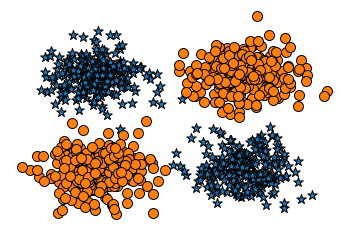

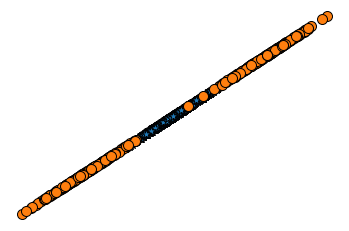

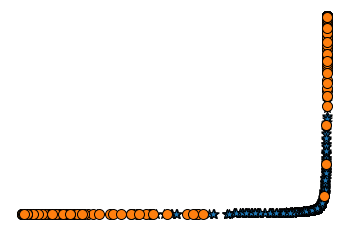

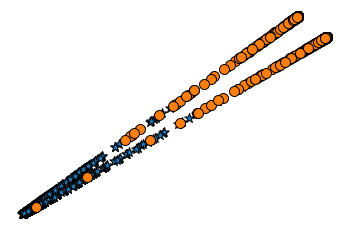

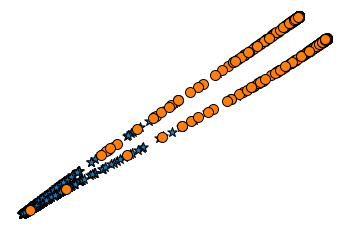

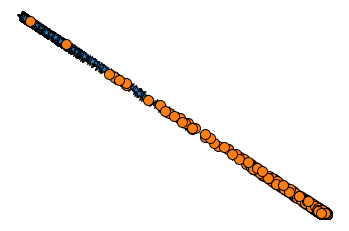

In [15]:
def plot_intermediate_representations(x_data, y_truth, mlp_model):
    y_pred = mlp_model(x_data)
    
    for data in mlp_model.last_forward_cache:
        blue, orange = [], []
        for (x1_i, x2_i), y_true_i in zip(data, y_truth):
            if y_true_i == 1:
                blue.append([x1_i, x2_i])
            else:
                orange.append([x1_i, x2_i])

        if blue:
            blue = np.stack(blue)
            plt.scatter(blue[:,0], blue[:,1], c="tab:blue", edgecolor="black", marker="*", s=100)                

        if orange:
            orange = np.stack(orange)
            plt.scatter(orange[:,0], orange[:,1], c="tab:orange", edgecolor="black", marker="o", s=100)

        plt.axis("off")
        plt.show()
        print()

plot_intermediate_representations(x_data_static, y_truth_static, mymlp2)


# 3D Plot

In [16]:
x = x_data_static[:,0]
y = x_data_static[:,1]
z = mymlp2(x_data_static, apply_softmax=True).detach()

_, y_pred = torch.max(z, dim=1)
falses = (y_pred != y_truth_static).nonzero().squeeze()
y_pred[falses] = 2

fig = px.scatter_3d(x=x, y=y, z=z[:,0], color=y_pred)
fig.update_traces(marker_size=3)